### Database with 6*6 images

shapes : square, triangle, cirle
colors : light red, light blue, light yellow, light green

dataset size : 5000

probability to have a symbol at each position : 0.5

Small database to develop counterfactual generation feature


In [1]:
import os

db_dir = os.environ["DATA"] + "PatImgXAI_data/dblocaltest0.1/"
os.makedirs(db_dir, exist_ok=True)

In [2]:
from xaipatimg.datagen.dbimg import load_db

db = load_db(db_dir)

In [4]:
# Number of images generated
NBGEN = 100000

# Grid division of each image
X_DIVISIONS = 6
Y_DIVISIONS = 6

# Size of the images in pixels
img_size = (700, 700)

# Probability to generate a geometrical shape at each position in the grid
SHAPE_PROB = 0.5

# Define available shapes
SHAPES = ['circle', 'square', 'triangle']
COLORS  = ["#F86C62", "#7AB0CD", "#F4D67B", "#87C09C"]

In [5]:
import numpy as np
from xaipatimg.datagen.dbimg import generate_uuid
import os

to_generate = NBGEN
unique_content_generated = {}
duplicate_count = 0
while to_generate > 0:
    content = []
    for i in range(X_DIVISIONS):
        for j in range(Y_DIVISIONS):
            if np.random.random() < SHAPE_PROB:
                content.append({
                    "shape": np.random.choice(SHAPES),
                    "pos": (i, j),
                    "color": np.random.choice(COLORS)
                })

    if str(content) in unique_content_generated:
        duplicate_count += 1
        continue

    imgid = generate_uuid()
    db[imgid] = {
        "path": os.path.join("img", imgid + ".png"),
        "division" : (X_DIVISIONS, Y_DIVISIONS),
        "size": img_size,
        "content": content
    }

    unique_content_generated[str(content)] = True
    to_generate -= 1

print("unique generated in DB : " + str(len(db)))
print("duplicates avoided : " + str(duplicate_count))

unique generated in DB : 100000
duplicates avoided : 0


In [6]:
import tqdm

content_dict = {}
nb_duplicates = 0

for k, v in tqdm.tqdm(db.items()):
    if str(v["content"]) in content_dict:
        nb_duplicates += 1
    else:
        content_dict[str(v["content"])] = True

print(nb_duplicates)

100%|██████████| 100000/100000 [00:01<00:00, 51231.76it/s]

0


In [7]:
from xaipatimg.datagen.genimg import gen_img_and_save_db
gen_img_and_save_db(db, db_dir, overwrite=False, n_jobs=20)

100%|██████████| 100000/100000 [01:40<00:00, 995.76it/s]


### Create dataset with rule : is there at least one row which contains only circles

In [8]:
import numpy as np

def extract_rows_with_only_circles(img_content):
    circles_counter = np.zeros(6,)
    non_circles_counter = np.zeros(6,)

    for c in img_content:
        if c["shape"] == "circle":
            circles_counter[c["pos"][1]] += 1
        else:
            non_circles_counter[c["pos"][1]] += 1

    return np.logical_and(circles_counter >= 1, non_circles_counter == 0)

def exist_row_with_only_circles(img_content):
    return np.sum(extract_rows_with_only_circles(img_content)) >= 1

In [10]:
from xaipatimg.datagen.gendataset import create_dataset_based_on_rule
import os
csv_name_train = "rowcircles_train.csv"
csv_name_test = "rowcircles_test.csv"
csv_name_valid = "rowcircles_valid.csv"
sample_img_path = os.path.join(db_dir, "datasets", "rowcircles_train")
create_dataset_based_on_rule(db_dir, csv_name_train, csv_name_test, csv_name_valid, test_size=200, valid_size=200,
                             dataset_pos_samples_nb=2000, dataset_neg_samples_nb=2000, rule_fun=exist_row_with_only_circles)

100%|██████████| 100000/100000 [00:00<00:00, 131940.83it/s]


Total number of positive instances found in database : 36191
Total number of negative instances found in database : 63809


In [11]:
from xaipatimg.datagen.gendataset import extract_sample_from_dataset
extract_sample_from_dataset(db_dir, csv_name_train, sample_img_path, 1000, 1000)

3601it [00:00, 59121.65it/s]


In [8]:
from xaipatimg.datagen.utils import gen_rand_sym, PatImgObj
import numpy as np
COLORS  = ["#F86C62", "#7AB0CD", "#F4D67B", "#87C09C"]

def rowcircles_counterfactuals(img_entry, is_pos, nb_cf):

    output_cf = []

    # Case we are searching for negative counterfactuals
    if is_pos:

        # Extracting indices of lines with only circles
        rows_with_only_circles = np.nonzero(extract_rows_with_only_circles(img_entry["content"]))

        # Iterating over all counterfactuals to generate.
        for _ in range(nb_cf):

            patimgobj = PatImgObj(img_entry)

            # Randomly setting a non circle symbol in every row that only contains circles
            for j_row in rows_with_only_circles:
                print(np.random.choice(np.arange(img_entry["division"][0])))
                print(gen_rand_sym(shapes=["square", "triangle"], colors=COLORS))
                patimgobj.set_symbol(posx=np.random.choice(np.arange(img_entry["division"][0])),
                                     posy=j_row,
                                     value=gen_rand_sym(shapes=["square", "triangle"], colors=COLORS))

                output_cf.append(patimgobj.get_img_dict())

    # Case we are looking for a positive counterfactual
    else:
        patimgobj = PatImgObj(img_entry)

        # Creating the list of lines which are not empty in a random order
        non_empty_lines_rnd = np.diff(np.arange(img_entry["size"][1], patimgobj.get_empty_lines()))
        non_empty_lines_rnd.shuffle()

        for idx in range(min(nb_cf), len(non_empty_lines_rnd)):
            patimgobj = PatImgObj(img_entry)
            patimgobj.change_shapes_of_line(non_empty_lines_rnd[idx], "circle")
            output_cf.append(patimgobj.get_img_dict())

    return output_cf


In [15]:
from xaipatimg.ml.xai import generate_counterfactuals_resnet18

generate_counterfactuals_resnet18(db_dir, csv_name_valid, "", rowcircles_counterfactuals, 5, None, 1, None)

Using cache found in /home/jleguy/.cache/torch/hub/pytorch_vision_v0.10.0


FileNotFoundError: [Errno 2] No such file or directory: 'best_model'

In [4]:
entry = db["f16bfcc4688b11f0908cd4d8534cb0f8"]
entry

{'path': 'img/f16bfcc4688b11f0908cd4d8534cb0f8.png',
 'division': [6, 6],
 'size': [700, 700],
 'content': [{'shape': 'square', 'pos': [0, 2], 'color': '#87C09C'},
  {'shape': 'square', 'pos': [1, 0], 'color': '#F86C62'},
  {'shape': 'circle', 'pos': [1, 5], 'color': '#F86C62'},
  {'shape': 'triangle', 'pos': [2, 0], 'color': '#F86C62'},
  {'shape': 'circle', 'pos': [2, 1], 'color': '#87C09C'},
  {'shape': 'circle', 'pos': [3, 0], 'color': '#7AB0CD'},
  {'shape': 'circle', 'pos': [3, 2], 'color': '#7AB0CD'},
  {'shape': 'square', 'pos': [3, 3], 'color': '#87C09C'},
  {'shape': 'circle', 'pos': [4, 0], 'color': '#F86C62'},
  {'shape': 'circle', 'pos': [4, 1], 'color': '#F4D67B'},
  {'shape': 'circle', 'pos': [4, 3], 'color': '#7AB0CD'},
  {'shape': 'circle', 'pos': [4, 4], 'color': '#87C09C'},
  {'shape': 'circle', 'pos': [5, 1], 'color': '#F4D67B'},
  {'shape': 'square', 'pos': [5, 4], 'color': '#F86C62'}]}

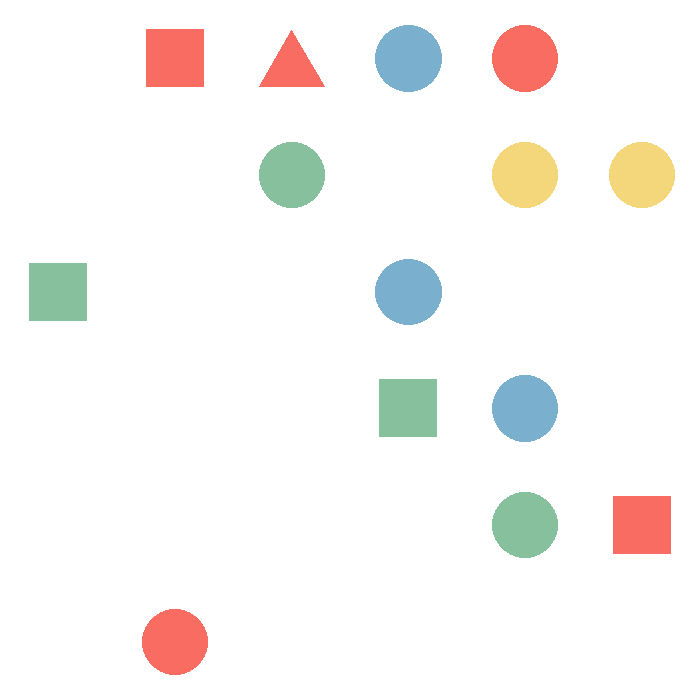

In [6]:
from IPython.display import Image, display

display(Image(filename=os.path.join(db_dir, entry["path"])))